# CNN Training Results Analysis

**ESM2 Contact Prediction - MLflow-Integrated Analysis**

This notebook analyzes CNN training results with MLflow integration, focusing on key performance metrics, training dynamics, and model evaluation.

In [1]:
# Setup and imports
import sys
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
if str(Path.cwd().parent) not in sys.path:
    sys.path.insert(0, str(Path.cwd().parent))

# Data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# MLflow imports
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

# Project imports (note: these are optional for analysis)
try:
    from src.esm2_contact.training.dataset import CNNContactDataset
    from src.esm2_contact.training.model import BinaryContactCNN
    from src.esm2_contact.training.metrics import ContactMetrics
    print("✅ Project imports successful")
except ImportError as e:
    print(f"⚠️ Optional project imports not available: {e}")
    print("   This is fine for analysis - continuing without project modules")

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

print("✅ Core imports successful")
print(f"📁 Working directory: {Path.cwd()}")

⚠️ Optional project imports not available: cannot import name 'CNNContactDataset' from 'src.esm2_contact.training.dataset' (/home/calmscout/Projects/PythonProjects/esm2-contact-prediction/src/esm2_contact/training/dataset.py)
   This is fine for analysis - continuing without project modules
✅ Core imports successful
📁 Working directory: /home/calmscout/Projects/PythonProjects/esm2-contact-prediction/notebooks


In [2]:
# MLflow Configuration
import os
from pathlib import Path

# Configure MLflow tracking URI
project_root = Path.cwd().parent
mlflow.set_tracking_uri(f"file://{project_root}/mlruns")

# Experiment configuration
EXPERIMENT_CONFIG = {
    "full_data": {
        "experiment_name": "esm2_contact_training",
        "experiment_id": "329887396556374988", 
        "run_id": "4988988931424d8c9dfcb42c3a54ec2b",
        "description": "Full dataset (100%) training"
    },
    "ten_percent_actual": {
        "experiment_name": "train_on_10_percent_of_data",
        "experiment_id": "578492015405104462",
        "run_id": "4144e21794fe4272bc2d2cb2e2a096a9",
        "description": "10% dataset training"
    }
}

# Current experiment and output setup
CURRENT_EXPERIMENT = "ten_percent_actual"
config = EXPERIMENT_CONFIG[CURRENT_EXPERIMENT]

print(f"🎯 Current experiment: {config['description']}")

🎯 Current experiment: 10% dataset training


## MLflow Data Loading

In [3]:
# MLflow Data Loading
client = MlflowClient()
mlflow_data = None

def load_mlflow_data(experiment_id, run_id, experiment_name):
    """Load MLflow data with basic error handling"""
    try:
        run = client.get_run(run_id)
        print(f"✅ Loaded run: {run.info.run_name} (Status: {run.info.status})")
        
        # Extract key metrics
        metrics = {}
        for metric_key in ['train_loss', 'val_loss', 'val_auc', 'best_val_auc']:
            try:
                metric_history = client.get_metric_history(run_id, metric_key)
                if metric_history:
                    metrics[metric_key] = [m.value for m in metric_history]
            except:
                pass
        
        return {
            'run_id': run_id,
            'experiment_name': experiment_name,
            'status': run.info.status,
            'metrics': metrics,
            'params': dict(run.data.params) if run.data.params else {}
        }
        
    except Exception as e:
        print(f"❌ Error loading MLflow data: {e}")
        return None

# Load data
if config["experiment_id"] and config["run_id"]:
    mlflow_data = load_mlflow_data(
        config["experiment_id"], 
        config["run_id"],
        config["experiment_name"]
    )

if mlflow_data:
    print(f"📊 Available metrics: {list(mlflow_data['metrics'].keys())}")
else:
    print("❌ No MLflow data available")

✅ Loaded run: run_20251103_013820 (Status: FINISHED)
📊 Available metrics: ['train_loss', 'val_loss', 'val_auc', 'best_val_auc']


## Training Dynamics

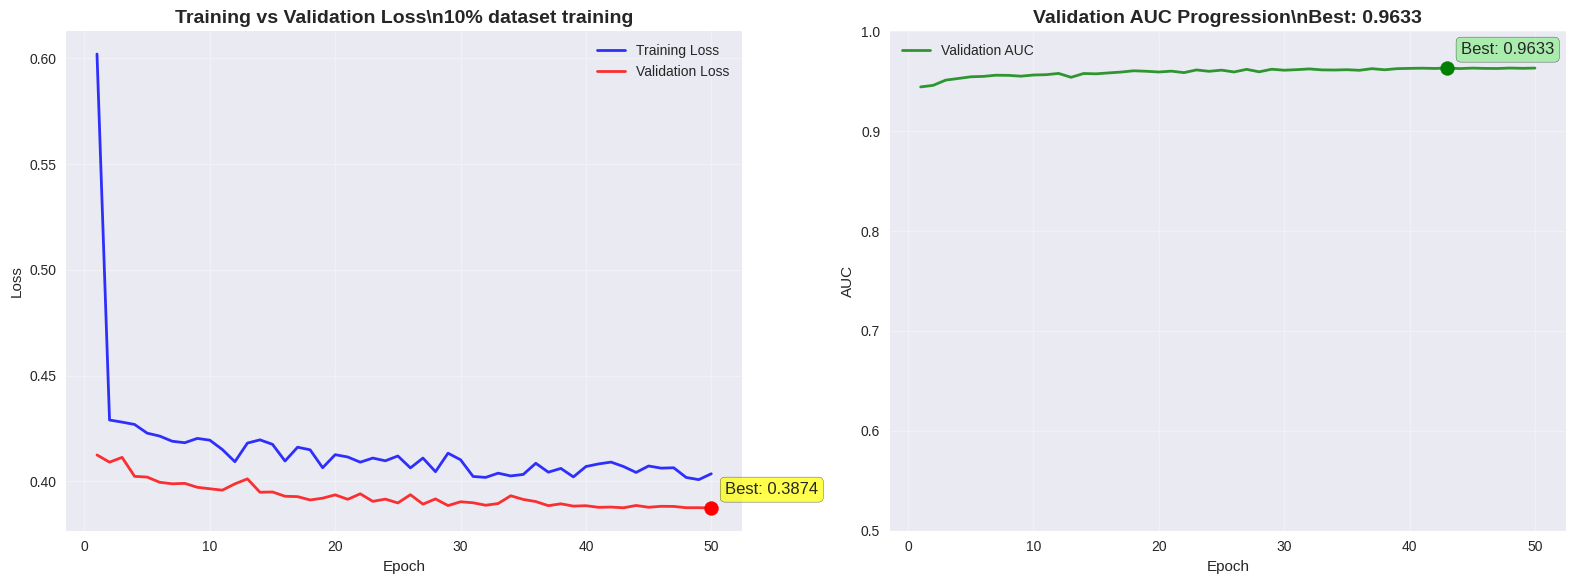

🎯 TRAINING RESULTS:
   Best Validation Loss: 0.387435 (Epoch 50)
   Best Validation AUC: 0.963255 (Epoch 43)
   🎉 EXCELLENT: High performance achieved!
   ✅ Training convergence: Good


In [4]:
# Training Dynamics - Main Analysis
if mlflow_data and mlflow_data['metrics']:
    metrics = mlflow_data['metrics']
    train_loss = metrics.get('train_loss', [])
    val_loss = metrics.get('val_loss', [])
    val_auc = metrics.get('val_auc', [])
    best_val_auc_metric = metrics.get('best_val_auc', [])
    
    if train_loss and val_loss:
        # Create large, clean plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Training vs Validation Loss
        epochs_train = range(1, len(train_loss) + 1)
        epochs_val = range(1, len(val_loss) + 1)
        
        ax1.plot(epochs_train, train_loss, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
        ax1.plot(epochs_val, val_loss, 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
        
        # Mark best validation loss
        best_val_loss_idx = np.argmin(val_loss)
        best_val_loss = val_loss[best_val_loss_idx]
        ax1.scatter([best_val_loss_idx + 1], [best_val_loss], color='red', s=100, zorder=5)
        ax1.annotate(f'Best: {best_val_loss:.4f}', 
                    xy=(best_val_loss_idx + 1, best_val_loss),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        ax1.set_title(f'Training vs Validation Loss\\n{config["description"]}', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # AUC Progression
        if val_auc:
            epochs_auc = range(1, len(val_auc) + 1)
            ax2.plot(epochs_auc, val_auc, 'g-', linewidth=2, label='Validation AUC', alpha=0.8)
            
            # Mark best AUC
            best_auc_idx = np.argmax(val_auc)
            best_auc = val_auc[best_auc_idx]
            ax2.scatter([best_auc_idx + 1], [best_auc], color='green', s=100, zorder=5)
            ax2.annotate(f'Best: {best_auc:.4f}', 
                        xy=(best_auc_idx + 1, best_auc),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
            
            ax2.set_title(f'Validation AUC Progression\\nBest: {best_auc:.4f}', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('AUC')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim([0.5, 1.0])
        else:
            ax2.text(0.5, 0.5, 'No AUC data available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('AUC Data Unavailable')
        
        plt.tight_layout()
        plt.show()
        
        # Print key results
        print("🎯 TRAINING RESULTS:")
        print(f"   Best Validation Loss: {best_val_loss:.6f} (Epoch {best_val_loss_idx + 1})")
        if val_auc:
            print(f"   Best Validation AUC: {best_auc:.6f} (Epoch {best_auc_idx + 1})")
            
            # Performance assessment based on absolute AUC value
            if best_auc > 0.95:
                print(f"   🎉 EXCELLENT: High performance achieved!")
            elif best_auc > 0.90:
                print(f"   ✅ GOOD: Solid performance")
            else:
                print(f"   📊 Performance: {best_auc:.6f}")
        
        # Convergence check
        if len(val_loss) > 10:
            recent_trend = np.mean(val_loss[-3:]) - np.mean(val_loss[-10:-3])
            if recent_trend > 0.001:
                print(f"   ⚠️ Watch for: Validation loss increasing")
            else:
                print(f"   ✅ Training convergence: Good")
    
else:
    print("❌ No training data available for visualization")

## Performance Summary

In [5]:
# Performance Metrics Summary
if mlflow_data and mlflow_data['metrics']:
    metrics = mlflow_data['metrics']
    params = mlflow_data['params']
    
    # Extract key metrics
    val_auc = metrics.get('val_auc', [])
    val_loss = metrics.get('val_loss', [])
    best_val_auc_metric = metrics.get('best_val_auc', [])
    
    # Get best values
    best_auc = max(val_auc) if val_auc else (best_val_auc_metric[0] if best_val_auc_metric else None)
    best_loss = min(val_loss) if val_loss else None
    final_auc = val_auc[-1] if val_auc else best_auc
    epochs_trained = len(val_auc) if val_auc else 0
    
    # Create summary data
    summary_data = []
    
    # Performance metrics
    if best_auc:
        summary_data.append(['Best Validation AUC', f"{best_auc:.4f}"])
    
    if best_loss:
        summary_data.append(['Best Validation Loss', f"{best_loss:.6f}"])
    
    if final_auc:
        summary_data.append(['Final AUC', f"{final_auc:.4f}"])
    
    summary_data.append(['Training Epochs', str(epochs_trained)])
    
    # Training parameters
    if params:
        key_params = ['max_epochs', 'batch_size', 'learning_rate']
        for param in key_params:
            if param in params:
                summary_data.append([param.replace('_', ' ').title(), str(params[param])])
    
    # Display summary
    if summary_data:
        print("📊 PERFORMANCE SUMMARY")
        print("=" * 40)
        
        df_summary = pd.DataFrame(summary_data, columns=['Metric', 'Value'])
        display(df_summary)
    
else:
    print("❌ No metrics data available for summary")

📊 PERFORMANCE SUMMARY


,Metric,Value
0,Best Validation AUC,0.9633
1,Best Validation Loss,0.387435
2,Final AUC,0.9632
3,Training Epochs,50
4,Batch Size,4
5,Learning Rate,0.001


In [9]:
# Executive Summary
print("📋 EXECUTIVE SUMMARY")
print("=" * 50)

if mlflow_data and mlflow_data['metrics']:
    metrics = mlflow_data['metrics']
    params = mlflow_data['params']
    
    # Key performance indicators
    val_auc = metrics.get('val_auc', [])
    val_loss = metrics.get('val_loss', [])
    best_val_auc_metric = metrics.get('best_val_auc', [])
    
    # Get best values
    best_auc = max(val_auc) if val_auc else (best_val_auc_metric[0] if best_val_auc_metric else None)
    best_loss = min(val_loss) if val_loss else None
    epochs_trained = len(val_auc) if val_auc else 0
    
    print(f"🎯 Experiment: {config['description']}")
    print(f"📊 Status: {mlflow_data['status']}")
    print()
    
    if best_auc:
        print("🏆 PERFORMANCE RESULTS:")
        print(f"   Best AUC: {best_auc:.4f}")
        
        # Performance assessment based on absolute AUC value
        if best_auc > 0.95:
            print("   🎉 EXCELLENT: High performance achieved!")
        elif best_auc > 0.90:
            print("   ✅ GOOD: Solid performance")
        else:
            print("   📊 Performance requires improvement")
        
        print()
    
    print("⚙️ TRAINING CONFIGURATION:")
    if params:
        for param in ['max_epochs', 'batch_size', 'learning_rate']:
            if param in params:
                print(f"   • {param.replace('_', ' ').title()}: {params[param]}")
    print()
    
    print("🎯 RECOMMENDATIONS:")
    
    if best_auc and best_auc > 0.95:
        print("   🚀 High performance achieved")
        print("   • Document this configuration for production use")
        print("   • Consider deployment for inference tasks")
    elif best_auc and best_auc < 0.85:
        print("   🔧 Performance needs improvement")
        print("   • Consider hyperparameter tuning")
        print("   • Review data quality and preprocessing")
    else:
        print("   ✅ Performance is acceptable")
        print("   • Ready for deployment consideration")
        print("   • Focus on inference optimization")
    
    print("   🔬 Next steps:")
    print("   • Validate on external protein structures")
    print("   • Set up monitoring for production use")

else:
    print("❌ No data available for summary")
    print("   Please check MLflow data loading")

📋 EXECUTIVE SUMMARY
🎯 Experiment: 10% dataset training
📊 Status: FINISHED

🏆 PERFORMANCE RESULTS:
   Best AUC: 0.9633
   🎉 EXCELLENT: High performance achieved!

⚙️ TRAINING CONFIGURATION:
   • Batch Size: 4
   • Learning Rate: 0.001

🎯 RECOMMENDATIONS:
   🚀 High performance achieved
   • Document this configuration for production use
   • Consider deployment for inference tasks
   🔬 Next steps:
   • Validate on external protein structures
   • Set up monitoring for production use
